In [2]:
# Chooose high volume, high activity stocks like historically high volume, premarket movers, tech sectors
# Define breakout rule: price breaching 20 period rolling max/min price and volume breaching rolling max volume
# Based on the signal go long/short
#Define exit/stop loss signal: previous plus/minus 20 period ATR as the rolling stop loss price
#Backtest the strategy by calculating cumulative return for each stock

In [25]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import copy
import time
import datetime as dt
import yfinance as yf

In [11]:
def CAGR(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["ret"]).cumprod()
    n=len(df)/(252*78) #252 trading days #252*6.5 trading hours #252*6.5*12 (5mins)
    CAGR=(df["cum_return"][-1])**(1/n) -1
    return CAGR

In [14]:
def volatility(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    vol=df["ret"].std()*np.sqrt(252*78)  #252 as it is day candle stick #52 if it is week candle stick
    return vol

In [15]:
def sharpe(DF,rf):
    df=DF.copy()
    return ((CAGR(df)-rf)/volatility(df))

In [16]:
def max_dd(DF):
    df=DF.copy()
    #df["return"]=df["Adj Close"].pct_change()
    df["cum_return"]=(1+df["ret"]).cumprod()
    df["cum_roll_max"]=df["cum_return"].cummax()
    df["drawdown"]=df["cum_roll_max"]-df["cum_return"]
    df["drawdown_pct"]=df["drawdown"]/df["cum_roll_max"]
    return df["drawdown_pct"].max()

In [17]:
def ATR(DF,n=14):
    df=DF.copy()
    df["H-L"]=df["High"]-df["Low"]
    df["H-PC"]=df["High"]-df["Adj Close"].shift(1)
    df["L-PC"]=df["Low"]-df["Adj Close"].shift(1)
    df["TR"]=df[["H-L","H-PC","L-PC"]].max(axis=1,skipna=False)
    df["ATR"]=df["TR"].ewm(com=n,min_periods=n).mean()
    return df["ATR"]

In [38]:
 tickers=["MSFT","AAPL","META","AMZN","INTC", "CSCO","VZ","IBM","TSLA","AMD"]

In [39]:
ohlc_intra={} #directory with ohlc value for each stock
start=dt.datetime.today()-dt.timedelta(days=7)
end=dt.datetime.today()

for ticker in tickers:
    ohlc_intra[ticker]=yf.download(ticker,start=start,end=end,interval='1m')
    ohlc_intra[ticker].dropna(inplace=True,how="all")

tickers=ohlc_intra.keys()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [40]:
ohlc_intra

{'MSFT':                                  Open        High         Low       Close  \
 Datetime                                                                    
 2022-08-02 09:30:00-04:00  276.000000  276.000000  274.850006  275.059998   
 2022-08-02 09:31:00-04:00  275.149994  276.000000  274.910004  275.880005   
 2022-08-02 09:32:00-04:00  275.910004  276.015015  275.059998  275.470001   
 2022-08-02 09:33:00-04:00  275.500000  275.920013  275.130005  275.260010   
 2022-08-02 09:34:00-04:00  275.179993  275.679993  275.049988  275.669006   
 ...                               ...         ...         ...         ...   
 2022-08-08 15:56:00-04:00  280.299988  280.334991  280.279999  280.279999   
 2022-08-08 15:57:00-04:00  280.279999  280.450012  280.209991  280.399994   
 2022-08-08 15:58:00-04:00  280.409912  280.599915  280.399994  280.470001   
 2022-08-08 15:59:00-04:00  280.484985  280.649994  280.320007  280.350006   
 2022-08-08 16:00:00-04:00  280.320007  280.320007  280.

# calculating ATR and rolling max price for each stock and consolidating this info by stock in a seperate dataframe

In [42]:
ohlc_dict=copy.deepcopy(ohlc_intra)
tickers_signal={}
tickers_ret={}
for ticker in tickers:
    print("calculating ATR and rolling max price for",ticker)
    ohlc_dict[ticker]["ATR"]=ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"]=ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"]=ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"]=ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker]=""
    tickers_ret[ticker]=[0]

calculating ATR and rolling max price for MSFT
calculating ATR and rolling max price for AAPL
calculating ATR and rolling max price for META
calculating ATR and rolling max price for AMZN
calculating ATR and rolling max price for INTC
calculating ATR and rolling max price for CSCO
calculating ATR and rolling max price for VZ
calculating ATR and rolling max price for IBM
calculating ATR and rolling max price for TSLA
calculating ATR and rolling max price for AMD


In [43]:
ohlc_dict.keys()

dict_keys(['MSFT', 'AAPL', 'META', 'AMZN', 'INTC', 'CSCO', 'VZ', 'IBM', 'TSLA', 'AMD'])

In [67]:
ohlc_dict["MSFT"].loc['2022-08-02'][0:25]

,Open,High,Low,Close,Adj Close,Volume,ATR,roll_max_cp,roll_min_cp,roll_max_vol
Datetime,,,,,,,,,,
2022-08-02 09:50:00-04:00,274.500000,274.500000,274.250000,274.369995,274.369995,85331,0.450647,276.355011,274.250000,265191.0
2022-08-02 09:51:00-04:00,274.250000,274.329987,274.239990,274.300293,274.300293,83709,0.423857,276.355011,274.239990,265191.0
2022-08-02 09:52:00-04:00,274.000000,274.000000,273.820007,273.850006,273.850006,139572,0.406213,276.355011,273.820007,265191.0
2022-08-02 09:53:00-04:00,273.750000,273.760010,273.500000,273.575012,273.575012,109955,0.395890,276.355011,273.500000,265191.0
2022-08-02 09:54:00-04:00,273.500000,273.500000,273.269989,273.354614,273.354614,80244,0.384441,276.355011,273.269989,265191.0
2022-08-02 09:55:00-04:00,273.000000,273.200012,272.994995,273.200012,273.200012,105907,0.372317,276.355011,272.994995,265191.0
2022-08-02 09:56:00-04:00,273.250000,273.380005,273.059998,273.379913,273.379913,96236,0.368851,276.355011,272.994995,265191.0
2022-08-02 09:57:00-04:00,273.500000,273.940002,273.500000,273.899994,273.899994,102725,0.381289,276.355011,272.994995,265191.0
2022-08-02 09:58:00-04:00,274.000000,274.149994,273.970001,274.140015,274.140015,106994,0.372896,276.355011,272.994995,265191.0


In [76]:
!pip install mplfinance

In [77]:
import mplfinance as mpf

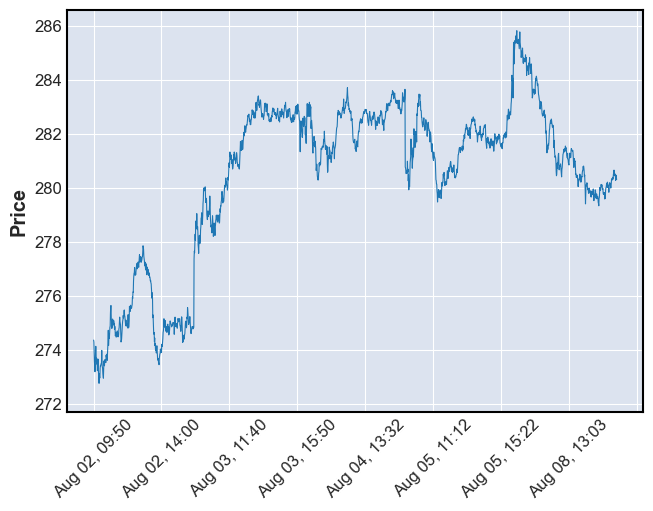

In [100]:
mpf.plot(data=ohlc_dict["MSFT"],type='line',volume=False,show_nontrading=False)

/Users/bikenkc/opt/anaconda3/lib/python3.9/site-packages/mplfinance/_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


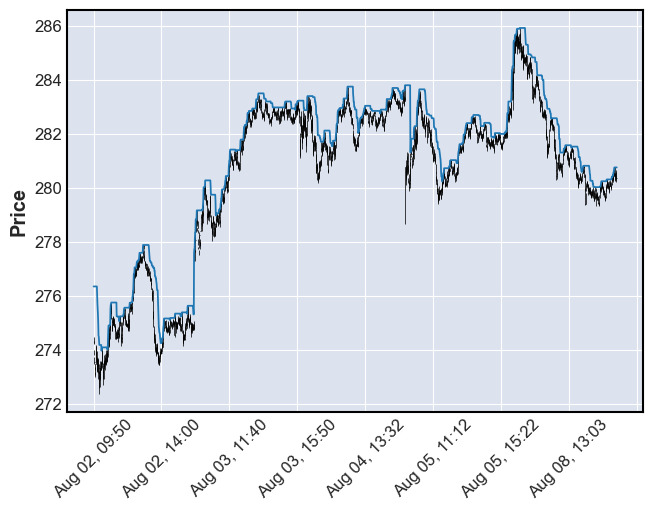

In [95]:
roll_max_plot=mpf.make_addplot(ohlc_dict["MSFT"]["roll_max_cp"])
mpf.plot(data=ohlc_dict["MSFT"],addplot=roll_max_plot)

/Users/bikenkc/opt/anaconda3/lib/python3.9/site-packages/mplfinance/_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


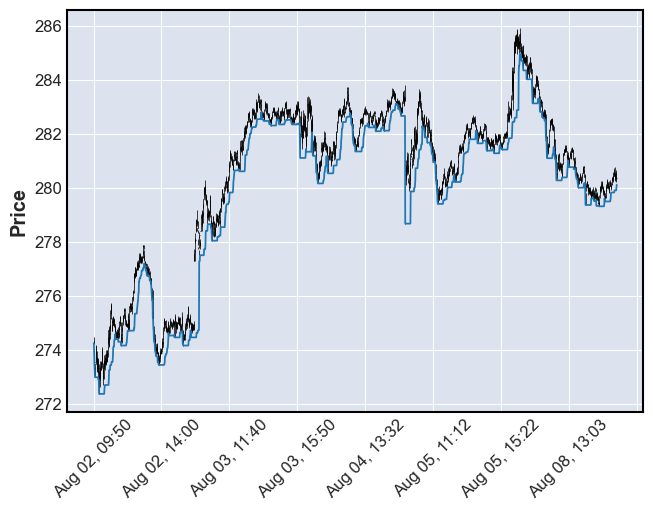

In [96]:
roll_min_plot=mpf.make_addplot(ohlc_dict["MSFT"]["roll_min_cp"])
mpf.plot(data=ohlc_dict["MSFT"],addplot=roll_min_plot)

In [97]:
tickers_signal

{'MSFT': '',
 'AAPL': '',
 'META': '',
 'AMZN': '',
 'INTC': '',
 'CSCO': '',
 'VZ': '',
 'IBM': '',
 'TSLA': '',
 'AMD': ''}

In [98]:
tickers_ret

{'MSFT': [0],
 'AAPL': [0],
 'META': [0],
 'AMZN': [0],
 'INTC': [0],
 'CSCO': [0],
 'VZ': [0],
 'IBM': [0],
 'TSLA': [0],
 'AMD': [0]}

In [101]:
ohlc_dict["MSFT"][0:5]

,Open,High,Low,Close,Adj Close,Volume,ATR,roll_max_cp,roll_min_cp,roll_max_vol
Datetime,,,,,,,,,,
2022-08-02 09:50:00-04:00,274.50,274.500000,274.250000,274.369995,274.369995,85331,0.450647,276.355011,274.250000,265191.0
2022-08-02 09:51:00-04:00,274.25,274.329987,274.239990,274.300293,274.300293,83709,0.423857,276.355011,274.239990,265191.0
2022-08-02 09:52:00-04:00,274.00,274.000000,273.820007,273.850006,273.850006,139572,0.406213,276.355011,273.820007,265191.0
2022-08-02 09:53:00-04:00,273.75,273.760010,273.500000,273.575012,273.575012,109955,0.395890,276.355011,273.500000,265191.0
2022-08-02 09:54:00-04:00,273.50,273.500000,273.269989,273.354614,273.354614,80244,0.384441,276.355011,273.269989,265191.0


In [107]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(1,len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:   #change of direction
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:  #change of direction
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating returns for  MSFT
calculating returns for  AAPL
calculating returns for  META
calculating returns for  AMZN
calculating returns for  INTC
calculating returns for  CSCO
calculating returns for  VZ
calculating returns for  IBM
calculating returns for  TSLA
calculating returns for  AMD


In [112]:
print(ohlc_dict["MSFT"])

                                 Open        High         Low       Close  \
Datetime                                                                    
2022-08-02 09:50:00-04:00  274.500000  274.500000  274.250000  274.369995   
2022-08-02 09:51:00-04:00  274.250000  274.329987  274.239990  274.300293   
2022-08-02 09:52:00-04:00  274.000000  274.000000  273.820007  273.850006   
2022-08-02 09:53:00-04:00  273.750000  273.760010  273.500000  273.575012   
2022-08-02 09:54:00-04:00  273.500000  273.500000  273.269989  273.354614   
...                               ...         ...         ...         ...   
2022-08-08 15:56:00-04:00  280.299988  280.334991  280.279999  280.279999   
2022-08-08 15:57:00-04:00  280.279999  280.450012  280.209991  280.399994   
2022-08-08 15:58:00-04:00  280.409912  280.599915  280.399994  280.470001   
2022-08-08 15:59:00-04:00  280.484985  280.649994  280.320007  280.350006   
2022-08-08 16:00:00-04:00  280.320007  280.320007  280.320007  280.320007   

In [113]:
#calculating overall strategy's KPIs
strategy_df=pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker]=ohlc_dict[ticker]["ret"]
strategy_df["ret"]=strategy_df.mean(axis=1)
print(CAGR(strategy_df))
print(sharpe(strategy_df,0.025))
print(max_dd(strategy_df))

0.12031428896800178
4.83695731556286
0.0029233317396103035


<AxesSubplot:xlabel='Datetime'>

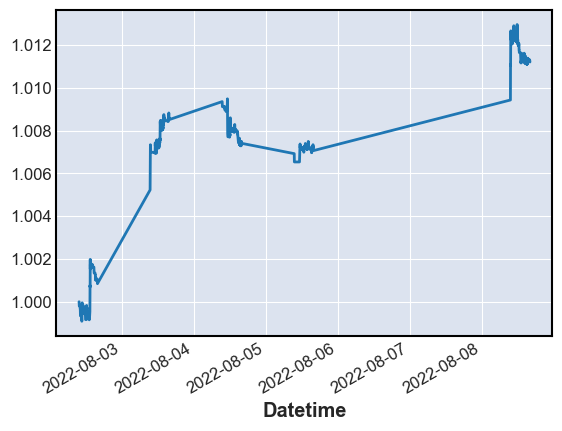

In [114]:
(1+strategy_df["ret"]).cumprod().plot()

In [115]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  META
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  TSLA
calculating KPIs for  AMD


In [116]:
KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
MSFT,0.008803,-0.708499,0.003784
AAPL,0.091788,2.336415,0.005508
META,0.159990,3.511182,0.005870
AMZN,0.326924,6.672752,0.006278
INTC,-0.064866,-3.308488,0.011924
CSCO,-0.036839,-2.685168,0.005878
VZ,0.090658,2.170943,0.004024
IBM,0.014793,-0.499420,0.003085
TSLA,0.169365,2.804648,0.009476
AMD,0.556079,3.776326,0.012268
